<a href="https://colab.research.google.com/github/Raghavisgeek/segmentation-model/blob/main/IMAGE_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet
!pip install -q matplotlib
!pip install -q pillow
!pip install -q torch torchvision

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
print("dataset downloaded and unzipped.")
!unzip -q chest-xray-pneumonia.zip -d /content/data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:25<00:00, 267MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.2MB/s]
dataset downloaded and unzipped.


(np.float64(-0.5), np.float64(1127.5), np.float64(623.5), np.float64(-0.5))

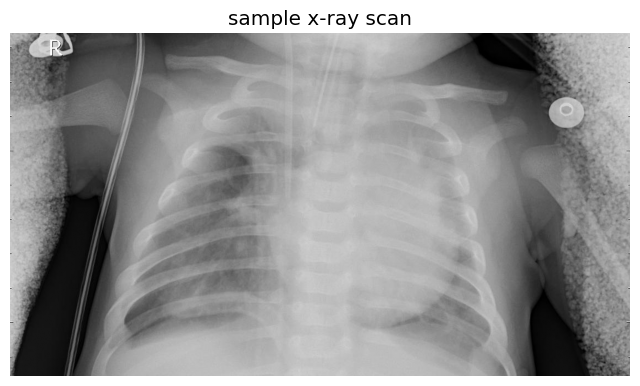

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('ggplot')
img_path = '/content/data/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'

img=Image.open(img_path)

plt.figure(figsize=(8,8)) #.figure is used to plot figure
plt.imshow(img, cmap='gray')#imshow
plt.title("sample x-ray scan")
plt.axis("off")

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

class XrayDataset(Dataset):
  def __init__(self,data_dir, transforms=None):
    self.normal_path = os.path.join(data_dir, 'NORMAL')
    self.pneumonia_path = os.path.join(data_dir, 'PNEUMONIA')

    self.normal_files=[os.path.join(self.normal_path,f) for f in os.listdir(self.normal_path)]
    self.pneumonia_files=[os.path.join(self.pneumonia_path, f) for f in os.listdir(self.pneumonia_path)]

    self.all_files=self.normal_files + self.pneumonia_files
    self.labels = [0]*len(self.normal_files)+[1]*len(self.pneumonia_files)
    self.transforms = transforms

  def __len__(self):
    return len(self.all_files)

  def __getitem__(self, idx):
    img_path = self.all_files[idx]
    label = self.labels[idx]

    image = Image.open(img_path).convert("RGB")

    if self.transforms:
      image = self.transforms(image)

    return image, torch.tensor(label, dtype=torch.long)

data_transform = transforms.Compose([ #transforms.RandomHorizontalFlip(),                                       transforms.RandomRotation(degrees=15),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                                      ])
train_dir = '/content/data/chest_xray/train'
train_dataset= XrayDataset(data_dir=train_dir, transforms=data_transform)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle= True)
images,labels= next(iter(train_loader))# for checking

val_dir = '/content/data/chest_xray/val'
val_dataset=XrayDataset(data_dir=val_dir, transforms=data_transform)
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=False)


test_dir = "/content/data/chest_xray/test"
test_dataset= XrayDataset(data_dir=test_dir, transforms=data_transform)

print(f"shape of one batch of images:{images.shape}")
print(f"shape of one batch of labels:{labels.shape}")
print(f"shape of full test dataset {len(test_dataset)}")

shape of one batch of images:torch.Size([32, 3, 224, 224])
shape of one batch of labels:torch.Size([32])
shape of full test dataset 624


In [6]:
from torchvision.models import resnet18
model = resnet18(pretrained = True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [7]:
#modify the last layer of the model
num_classes = 2
model.fc= torch.nn.Linear(model.fc.in_features, num_classes)

In [8]:
criterion= torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
def train(model,train_loader,val_loader, criterion, optimizer, num_epochs):
  device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")
  model.to(device) # Move model to the device
  # Path to save the model on your Google Drive
  save_path = '/content/drive/MyDrive/best_xray_model.pth'
  best_val_acc = 0.0 # Keep track of the best validation accuracy

  for epoch in range(num_epochs): # Changed epich to epoch for consistency
    model.train()
    running_loss=0.0
    running_corrects= 0

    # TRAINING LOOP
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs= model(inputs)
      _, preds= torch.max(outputs, 1) # Get indices from torch.max
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0) # Corrected loss calculation
      running_corrects += torch.sum(preds == labels.data) # Corrected correct predictions count

   #calculate metric after the loop
    train_loss = running_loss/len(train_loader.dataset)
    train_acc = running_corrects.float() / len(train_loader.dataset)

    model.eval()
    running_loss = 0.0
    running_corrects=0

    # VALIDATION LOOP
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels= labels.to(device)
        outputs = model(inputs)
        _, preds =torch.max(outputs, 1)
        loss = criterion(outputs,labels)
        running_loss += loss.item() * inputs.size(0) # Corrected loss calculation
        running_corrects += torch.sum(preds == labels.data) # Corrected correct predictions count

    val_loss=running_loss/len(val_loader.dataset)
    val_acc = running_corrects.float()/len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}],"
          f"rain loss: {train_loss:.4f}, train acc: {train_acc:.4f},"
          f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}") # Corrected print statement
    if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved to {save_path} with accuracy: {val_acc:.4f}")

In [11]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Using device: cuda
Epoch [1/5],rain loss: 0.2524, train acc: 0.8951,val loss: 0.5004, val acc: 0.6875
New best model saved to /content/drive/MyDrive/best_xray_model.pth with accuracy: 0.6875
Epoch [2/5],rain loss: 0.1642, train acc: 0.9365,val loss: 0.4343, val acc: 0.6875
Epoch [3/5],rain loss: 0.1468, train acc: 0.9450,val loss: 0.3846, val acc: 0.8125
New best model saved to /content/drive/MyDrive/best_xray_model.pth with accuracy: 0.8125
Epoch [4/5],rain loss: 0.1303, train acc: 0.9509,val loss: 0.5088, val acc: 0.6875
Epoch [5/5],rain loss: 0.1288, train acc: 0.9528,val loss: 0.4780, val acc: 0.6875
